# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [10]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [11]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [12]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.64382130753775

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [42]:
from sklearn.metrics import mean_squared_error

In [48]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """

    n_samples, n_features = X.shape
    all_predictions = np.zeros((num_runs, n_samples))
    out_of_bag_masks = []

    for _ in range(num_runs):
        # Дженерим бутстрап выборку
        indices = np.random.choice(n_samples, n_samples, replace=True)
        X_bootstrap, y_bootstrap = X[indices], y[indices]
        out_of_bag_mask = np.ones(n_samples, dtype=bool)
        out_of_bag_mask[indices] = False
        out_of_bag_masks.append(out_of_bag_mask)

        # Будет тренить на бутстрапе выборке 
        regressor.fit(X_bootstrap, y_bootstrap)

        # А делать предикты будем на out-og-bag выборке
        predictions = regressor.predict(X[out_of_bag_mask])
        all_predictions[_, out_of_bag_mask] = predictions

    # Считаем bias, variance и error
    bias_squared = np.mean((np.mean(all_predictions, axis=0) - y)**2)
    variance = np.mean(np.var(all_predictions, axis=0))
    error = np.mean((all_predictions - y.reshape(1, -1))**2)

    return np.sqrt(bias_squared), variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [50]:
compute_biase_variance(LinearRegression(), X, y)

(1.7979642422998328, 1.2061560956791306, 4.438831512267942)

In [51]:
compute_biase_variance(DecisionTreeRegressor(), X, y)

(1.8196561926309214, 1.569532728180275, 4.880681387560339)

In [52]:
compute_biase_variance(RandomForestRegressor(), X, y)

(1.8174705179816817, 1.218290450447399, 4.521489534180002)

__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

- Самая большая ошибка посчитана на решающем дереве, что неудевительно, так как это наиболее склонна к переобучению модель в этом стеке моделей.

- По линейной регрессии: все согласуется, небольшой разброс и большое смещение, так как вполне может быть, что реальная зависимость в данных нелинейна, следовательно модель может иметь высокое смещение. Модель слишком проста, она  недостаточно хорошо аппроксимирует данные, поэтому смещение больше.
- По решающему дереву: таааак, ну тут все сложненее, мы как минимум должным иметь большой разброс, ну собственно по сравнению с другими моделями, да, он большой. Еще на удивление, большое смещение, чего не должно быть, так как модель реально хорошо подстраивается под обучающие данные, но, по всей видимости, там большие шумы в данных.
- По рандомному лесу: Касаемо разброса, да, согласуется, засчет беггинга мы понижаем этот показателей и выигрываем по сравнению с одним деревом. А ситуация со смещением схожа с деревом, из-за больших шумов!

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__
В теории бэггинг (Bootstrap Aggregating) предполагается, что если базовые модели (например, деревья решений) независимы друг от друга, то разброс агрегированной модели (бэггинга) будет в k раз меньше разброса отдельной базовой модели, где k - количество базовых моделей в бэггинге.

Иными словами, если V - разброс отдельной базовой модели, то разброс бэггинга будет приблизительно равен V/k.
Это предположение основано на том, что при использовании бутстрап-выборок для обучения каждой базовой модели, эти модели становятся более независимыми. Последующее усреднение или агрегирование их предсказаний снижает изменчивость, что приводит к уменьшению разброса.

Ну и внизу, что ОЧЕНЬ ОЧЕНЬ ОЧЕНЬ долго ассамблируется, демонстрирует примерно такое поведение, наверное)))))))))

In [54]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Создаем базовые модели
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor()
forest_model = RandomForestRegressor()

# Создаем бэггинг над базовыми моделями
bagging_linear = BaggingRegressor(estimator=linear_model, n_estimators=10, random_state=42)
bagging_tree = BaggingRegressor(estimator=tree_model, n_estimators=10, random_state=42)
bagging_forest = BaggingRegressor(estimator=forest_model, n_estimators=10, random_state=42)

# Оцениваем модели
bias_bagging_linear, variance_bagging_linear, _ = compute_biase_variance(bagging_linear, X, y)
bias_bagging_tree, variance_bagging_tree, _ = compute_biase_variance(bagging_tree, X, y)
bias_bagging_forest, variance_bagging_forest, _ = compute_biase_variance(bagging_forest, X, y)

print("Bias and Variance for Bagging + Linear Regression:")
print(f"Bias: {bias_bagging_linear}, Variance: {variance_bagging_linear}")

print("\nBias and Variance for Bagging + Decision Tree:")
print(f"Bias: {bias_bagging_tree}, Variance: {variance_bagging_tree}")

print("\nBias and Variance for Bagging + Random Forest:")
print(f"Bias: {bias_bagging_forest}, Variance: {variance_bagging_forest}")


KeyboardInterrupt: 

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [55]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    test_indices = np.random.choice(len(X), num_test_objects, replace=False)
    X_test, y_test = X[test_indices], y[test_indices]

    # Оставшие объекты формируют обучающий набор
    train_indices = np.setdiff1d(np.arange(len(X)), test_indices)
    X_train, y_train = X[train_indices], y[train_indices]

    plt.figure(figsize=(10, 6))

    for _ in range(num_runs):
        # Дженерим бутстрап подвыборку
        bootstrap_indices = np.random.choice(len(X_train), len(X_train), replace=True)
        X_bootstrap, y_bootstrap = X_train[bootstrap_indices], y_train[bootstrap_indices]

        # Треним регрессор на бутстрап подвыборке
        regressor.fit(X_bootstrap, y_bootstrap)

        # Тестим на обычной тестовой выборке
        predictions = regressor.predict(X_test)

        plt.scatter(np.arange(num_test_objects), predictions, color='blue', alpha=0.05)

    plt.scatter(np.arange(num_test_objects), y_test, color='black', label='True values')

    plt.xlabel('Test Objects')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.legend()
    plt.show()

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

In [56]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

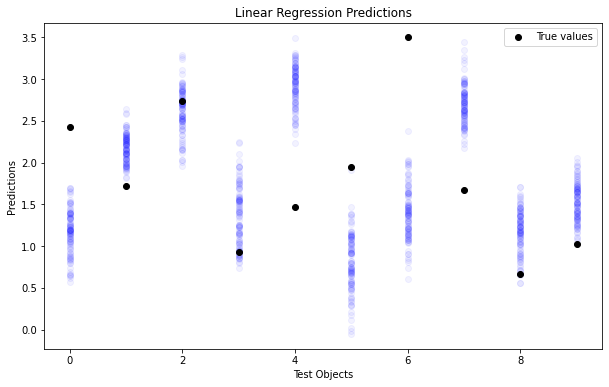

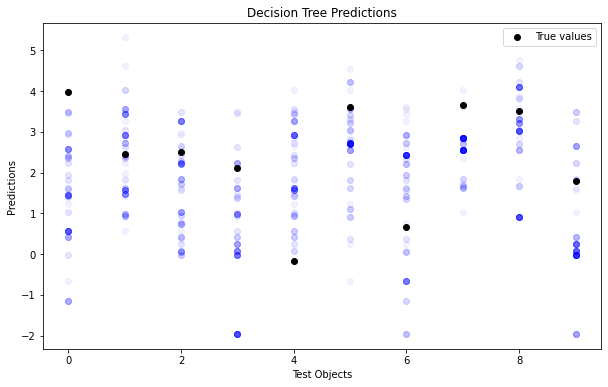

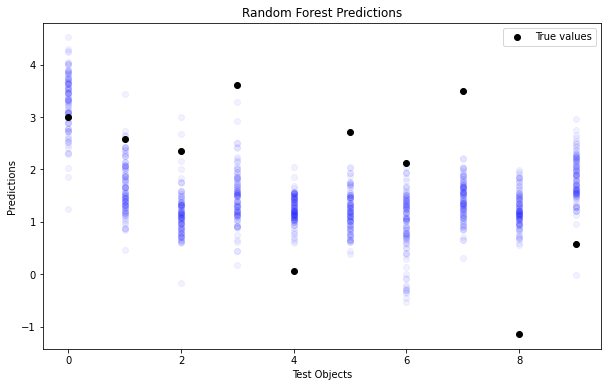

In [58]:
linear_regressor = LinearRegression()
tree_regressor = DecisionTreeRegressor()
forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)


plot_predictions(linear_regressor, X, y, title="Linear Regression Predictions")

plot_predictions(tree_regressor, X, y, title="Decision Tree Predictions")

plot_predictions(forest_regressor, X, y, title="Random Forest Predictions")
plt.show()

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__
- По первому графику мы имеем что синие точки и их ближайшие оттенки находятся на недолеком расстоянии друг от друга, но при этом черные находятся ОЧЕНЬ ДАЛЕКО ОТ ЦЕНТРА ЭТОГО СЛЕДА КОМЕТЫ, где-то по концам этих следов. Аналогичную ситуации мы видим и на третьем графике, но там концентрация синих точек еще больше сближена к центру своего следа. Все это говорит о большом смещении и маленьком разбросе.
- По второму графику мы видим, что черные точки лежат где-то близко к центру, однако следы комет становятся прерывистами и растягиваются на всю площадь. Все это говорит о маленьком смещении и большом разбросе.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [ ]:
### your code here

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [ ]:
### your code here

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__